# Лаба 1. Класифікація

Було обрано [датасет](https://archive.ics.uci.edu/dataset/763/land+mines-1) з показниками детектора мін для різних типів грунту, та різних типів наземних мін.

![table1](extras\table1.png "table2")

In [1]:
import pandas as pd

data = pd.read_csv("data\mine_data_norm.csv")
data.head(7)

,V,H,S,M
0,0.338157,0.000000,0.0,1
1,0.320241,0.181818,0.0,1
2,0.287009,0.272727,0.0,1
3,0.256284,0.454545,0.0,1
4,0.262840,0.545455,0.0,1
5,0.240966,0.727273,0.0,1
6,0.254410,0.818182,0.0,1


Дані в таблиці вже нормалізовані, але мені не подобається їхній спосіб перетворення типів грунту в числовий формат:

| Soil Type         | Number    |
| ----------------- | --------- |
| Dry and Sandy     | 0.0       |
| Dry and Humus     | 0.2       |
| Dry and Limy      | 0.4       |
| Humid and Sandy   | 0.6       |
| Humid and Humus   | 0.8       |
| Humid and Limy    | 1.0       |

І відповідно всі алгоритми, що використовують $L_k$ метрики (або навіть просто відстані на дійсних числах по цьому виміру), будуть вважати типи грунту "Dry and Sandy" та "Humid and Limy" дуже різними, а "Dry and Limy" та "Humid and Sandy" дуже подібними.

Тому розділимо цю фічу на дві: Humidity ("Humid" та "Dry") та Soil ("Sandy", "Humus" та "Limy"); а оскільки ці типи грунту всі є різними, то застосуємо One-Hot Encoding до фічі Soil: 

| Soil Type         | Humidity  | Sandy | Humus | Limy  |
| ----------------- | --------  | ----- | ----- | ----  |
| Dry and Sandy     | 0         | 1     | 0     | 0     |
| Dry and Humus     | 0         | 0     | 1     | 0     |
| Dry and Limy      | 0         | 0     | 0     | 1     |
| Humid and Sandy   | 1         | 1     | 0     | 0     |
| Humid and Humus   | 1         | 0     | 1     | 0     |
| Humid and Limy    | 1         | 0     | 0     | 1     |


In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Separate into separate Wet/Dry and Soil type
data['SH'] = (data.loc[:, 'S'] > 0.5).astype(float)
data['ST'] = (data.loc[:, 'S'] * 10) % 6

# One-Hot-Encoding of Soil types
enc_s = OneHotEncoder()
data[['Sandy', 'Humus', 'Limy']] = enc_s.fit_transform(data[['ST']]).toarray()

# Table cleaning
DF = data.drop(['ST', 'S'], axis=1)
DF = DF.drop(['M'], axis=1).join(DF['M'])
DF = DF.rename(columns={'V': 'Voltage', 'H': 'Height', 'SH': 'Humidity', 'M': 'Mine'})

DF.head()

,Voltage,Height,Humidity,Sandy,Humus,Limy,Mine
0,0.338157,0.000000,0.0,1.0,0.0,0.0,1
1,0.320241,0.181818,0.0,1.0,0.0,0.0,1
2,0.287009,0.272727,0.0,1.0,0.0,0.0,1
3,0.256284,0.454545,0.0,1.0,0.0,0.0,1
4,0.262840,0.545455,0.0,1.0,0.0,0.0,1


З цим датасетом і будемо працювати.

In [3]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Voltage   338 non-null    float64
 1   Height    338 non-null    float64
 2   Humidity  338 non-null    float64
 3   Sandy     338 non-null    float64
 4   Humus     338 non-null    float64
 5   Limy      338 non-null    float64
 6   Mine      338 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 18.6 KB


# Попередній аналіз та візуалізація
Таблиця кореляцій параметрів:

<Axes: >

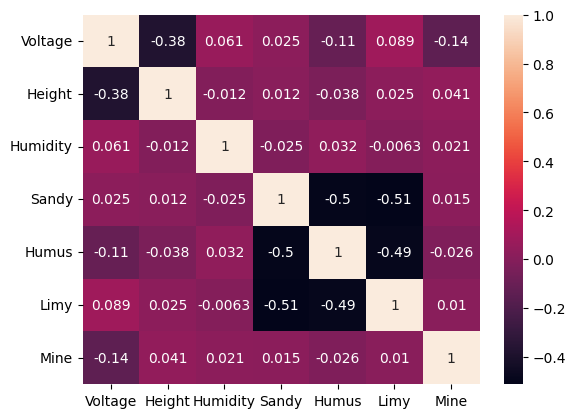

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(DF.corr(), annot=True)

Бачимо сильну від'ємну кореляцію різних типів землі, що зрозуміло, оскільки за побудовою земля одночасно може бути тільки одного із цих трьох типів.

Також бачимо значущу кореляцію висоти вимірювання та сили "магнітної аномалії", що також очікувано (напевно? я не фізик), оскільки чим більша відстань, тим слабшим має бути вимірювання.

['Voltage', 'Height', 'Humidity', 'Sandy', 'Humus', 'Limy']


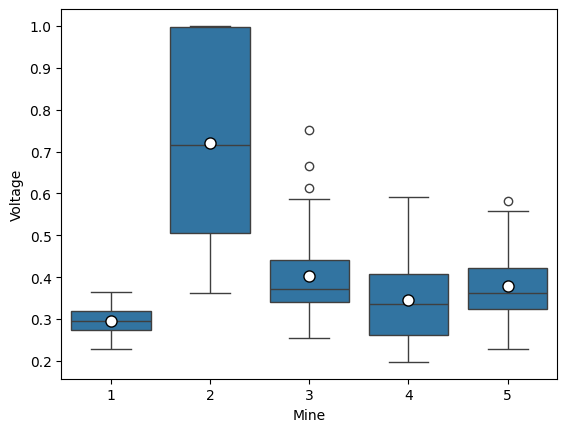

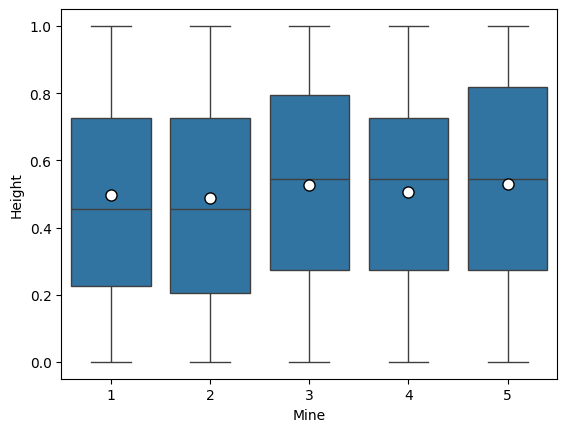

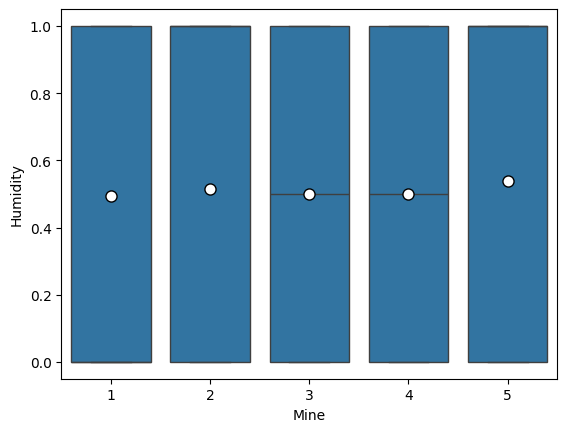

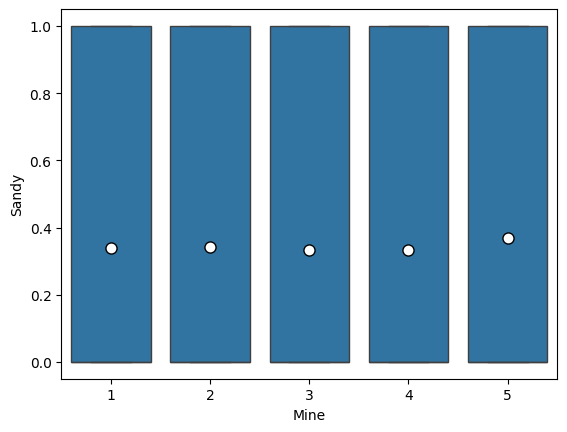

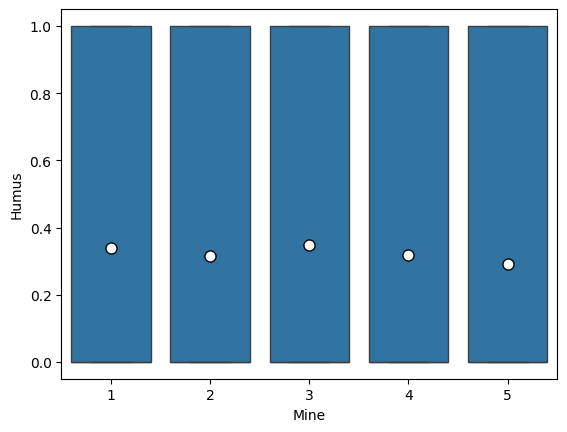

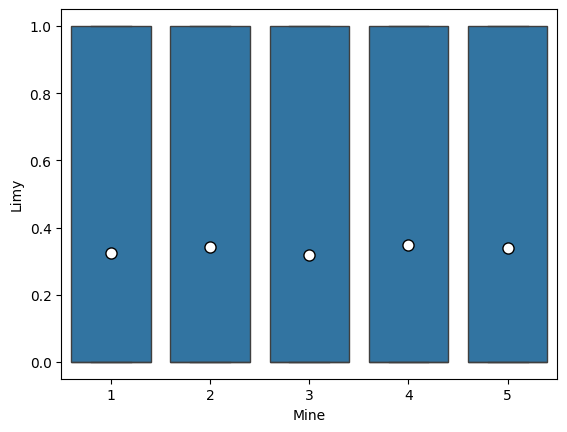

In [5]:
feature_names = list(DF.columns.values)[:-1]
print(feature_names)

for i in range(len(feature_names)):
    figure = plt.figure()
    ax = sns.boxplot(x='Mine', y=feature_names[i], data=DF, 
                     showmeans=True, 
                     meanprops={'marker':'o','markerfacecolor':'white','markeredgecolor':'black','markersize':'8'})

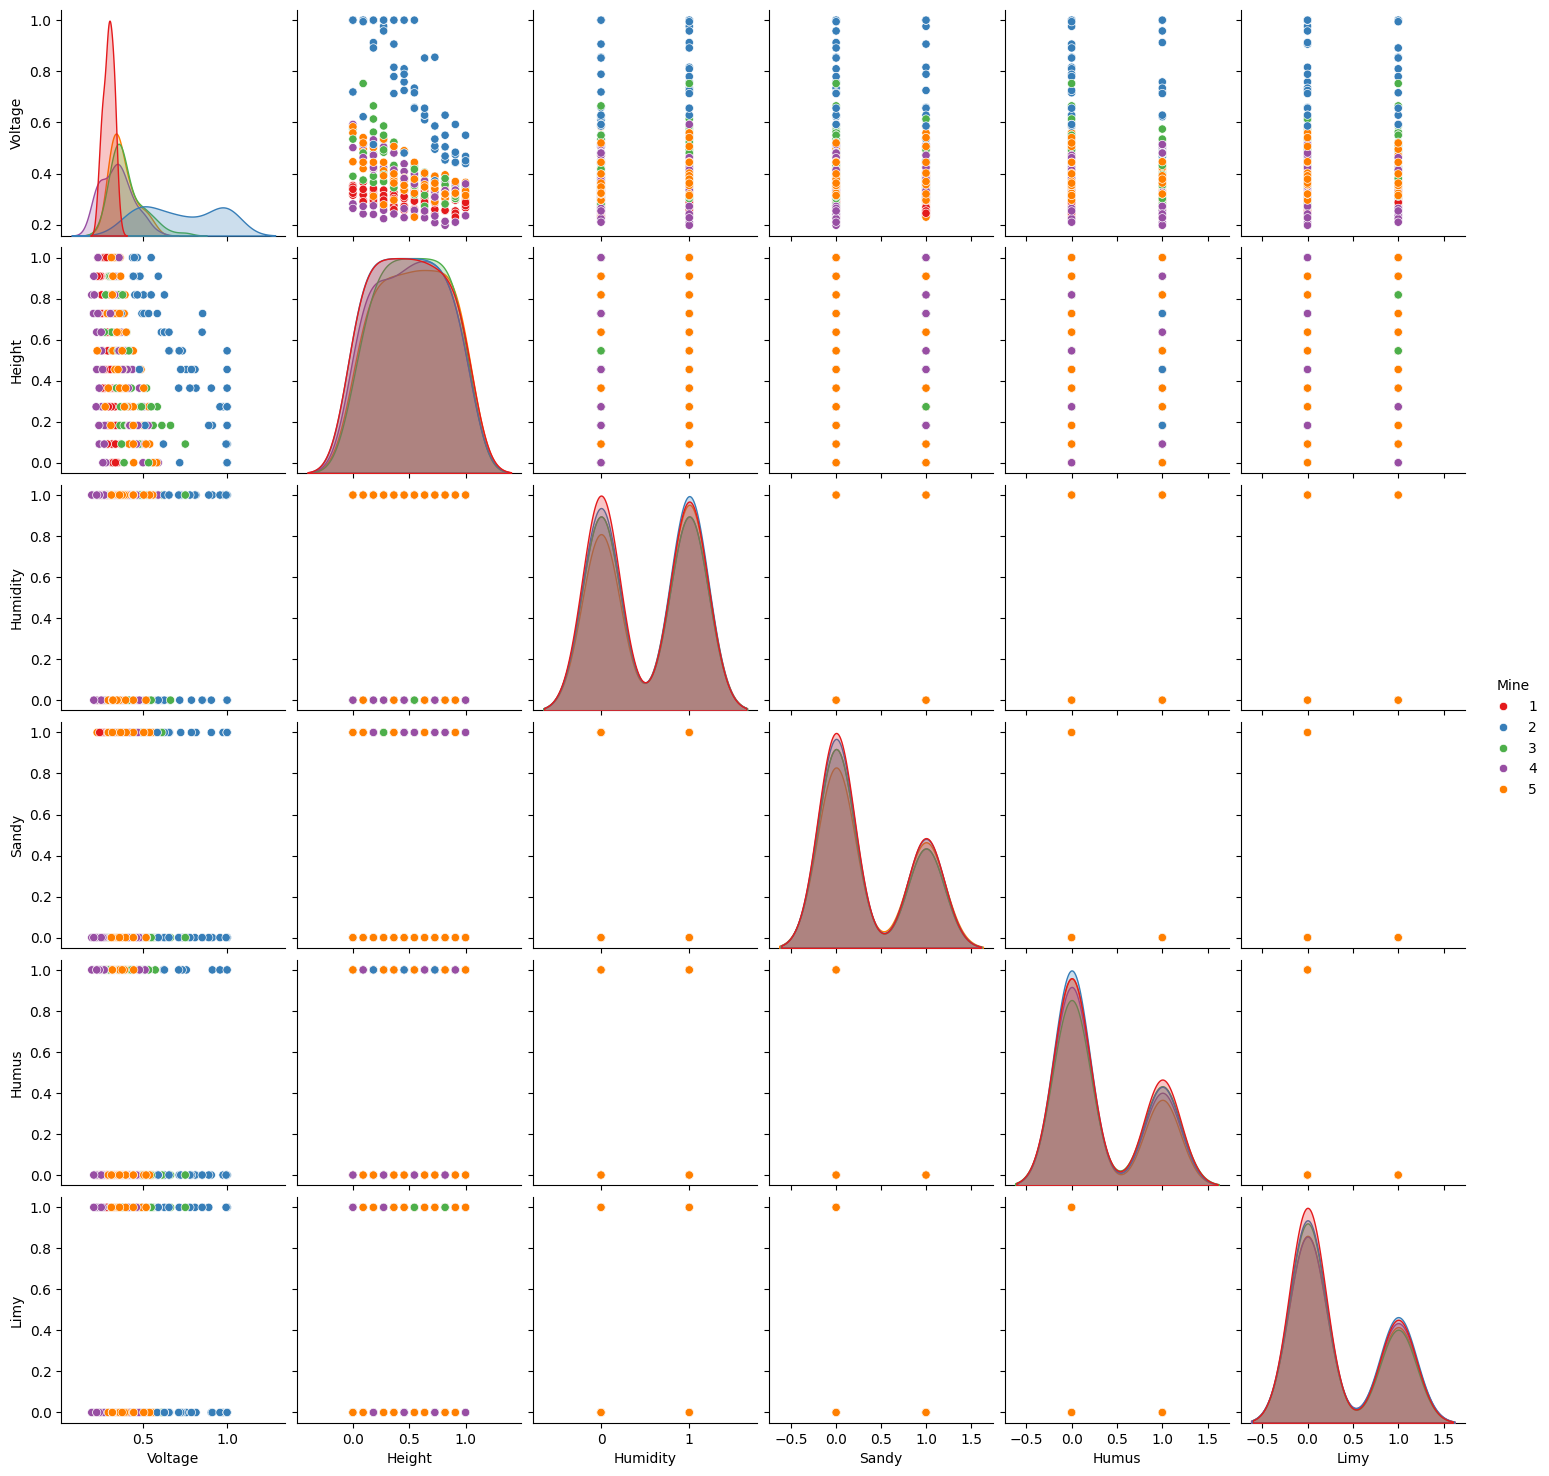

In [6]:
sns.pairplot(DF, hue="Mine", palette = 'Set1')

Бачимо помітну різницю в величині, варації та інтервалах значень вимірювань магнітної аномалії "Voltage" для різних типів мін, що добре :)


А також бачимо, що усі інші параметри, які описують умови вимірювання, мають приблизно однаковий розподіл для усіх типів мін. Що також є добре, оскільки такі дані більш вичерпно описують дійсність.

Для початку потрібно розділити дані на тренувальний та тестовий набори:

In [7]:
from sklearn.model_selection import train_test_split

enc_m = LabelEncoder()
enc_m.fit(["0.", "1. No mine", "2. Anti-Tank", "3. Anti-Personnel", "4. Booby-Trap", "5. M14"])
DF['Mine'] = enc_m.inverse_transform(DF['Mine'])
class_names = list(DF['Mine'].unique())

X = DF.drop(['Mine'], axis=1)
Y = DF['Mine']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# KNN


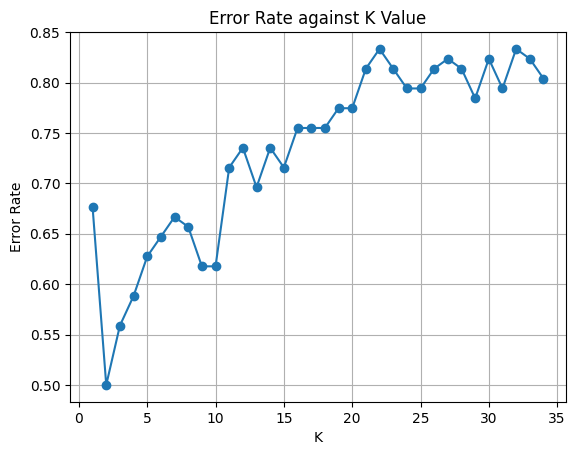

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score
import numpy as np

error_rate = []
K = range(1, 35)

for k in K:
    knn = KNeighborsClassifier(n_neighbors=k, p=2, weights='uniform')
    knn.fit(X_train, Y_train)
    pred = knn.predict(X_test)
    error_rate.append(np.mean(pred != Y_test)) 

plt.plot(K, error_rate, marker='o')
plt.title('Error Rate against K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.grid()


In [9]:
best_k = np.argmin(error_rate) + 1
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, Y_train)
pred = knn_final.predict(X_test)

print(f'Best value of k is {best_k}')
print(confusion_matrix(Y_test, pred))
print(classification_report(Y_test, pred))
KNN_score = accuracy_score(Y_test, pred)
print(KNN_score)

Best value of k is 2
[[17  0  3  0  0]
 [ 0 18  2  1  0]
 [ 8  0  7  6  0]
 [ 7  3  3  6  0]
 [ 7  1  6  4  3]]
                   precision    recall  f1-score   support

       1. No mine       0.44      0.85      0.58        20
     2. Anti-Tank       0.82      0.86      0.84        21
3. Anti-Personnel       0.33      0.33      0.33        21
    4. Booby-Trap       0.35      0.32      0.33        19
           5. M14       1.00      0.14      0.25        21

         accuracy                           0.50       102
        macro avg       0.59      0.50      0.47       102
     weighted avg       0.59      0.50      0.47       102

0.5


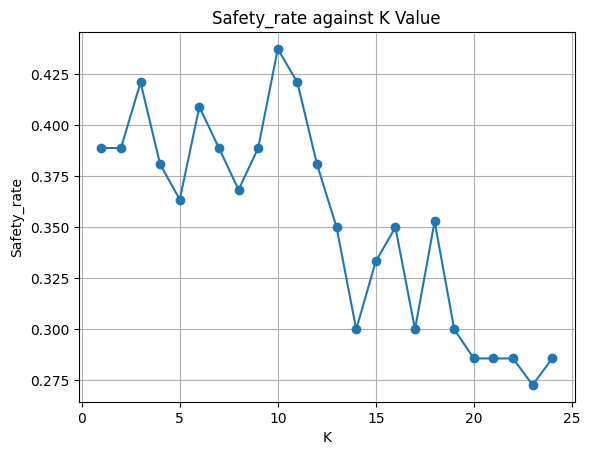

In [10]:
safety_rate = []
K = range(1, 25)

for k in K:
    knn = KNeighborsClassifier(n_neighbors=k, p=2, weights='distance')
    knn.fit(X_train, Y_train)
    pred = knn.predict(X_test)
    safety_rate.append(precision_score(Y_test, pred, average=None)[0])

    
plt.plot(K, safety_rate, marker='o')
plt.title('Safety_rate against K Value')
plt.xlabel('K')
plt.ylabel('Safety_rate')
plt.grid()

In [11]:
best_k = np.argmax(safety_rate) + 1
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, Y_train)
pred = knn_final.predict(X_test)

print(f'Best value of k is {best_k}')
print(confusion_matrix(Y_test, pred))
print(classification_report(Y_test, pred))
print(accuracy_score(Y_test, pred))

Best value of k is 10
[[14  0  0  6  0]
 [ 4 13  2  2  0]
 [ 6  1  6  7  1]
 [10  2  2  4  1]
 [ 8  2  8  1  2]]
                   precision    recall  f1-score   support

       1. No mine       0.33      0.70      0.45        20
     2. Anti-Tank       0.72      0.62      0.67        21
3. Anti-Personnel       0.33      0.29      0.31        21
    4. Booby-Trap       0.20      0.21      0.21        19
           5. M14       0.50      0.10      0.16        21

         accuracy                           0.38       102
        macro avg       0.42      0.38      0.36       102
     weighted avg       0.42      0.38      0.36       102

0.38235294117647056


# Decision Tree

[[16  0  1  1  2]
 [ 0 13  4  2  2]
 [ 4  2 11  3  1]
 [ 4  2  2  7  4]
 [ 2  1  6  4  8]]
                   precision    recall  f1-score   support

       1. No mine       0.62      0.80      0.70        20
     2. Anti-Tank       0.72      0.62      0.67        21
3. Anti-Personnel       0.46      0.52      0.49        21
    4. Booby-Trap       0.41      0.37      0.39        19
           5. M14       0.47      0.38      0.42        21

         accuracy                           0.54       102
        macro avg       0.54      0.54      0.53       102
     weighted avg       0.54      0.54      0.53       102

0.5392156862745098
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=3)


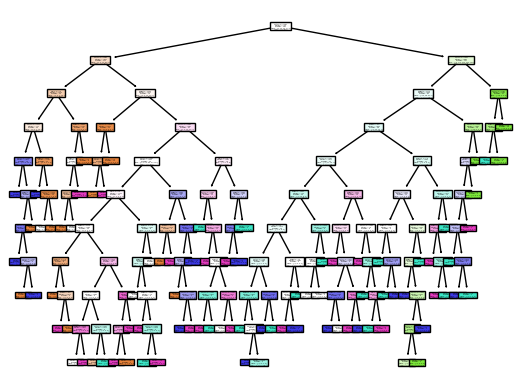

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV

param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
               'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
               'min_samples_leaf': [1, 2, 3, 4, 5, 6],
               'max_depth': [3, 4, 5, 6, 8, 10, 15]
               }

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit=True)

grid.fit(X_train, Y_train)


grid_predictions = grid.predict(X_test)

print(confusion_matrix(Y_test, grid_predictions))
print(classification_report(Y_test, grid_predictions))
DT_score = accuracy_score(Y_test, grid_predictions)
print(DT_score)
print(grid.best_estimator_)


# model = DecisionTreeClassifier(criterion='gini', min_samples_leaf=4, min_samples_split=8, max_depth=6)

# model.fit(X_train, Y_train)
# pred = model.predict(X_test)


# print(confusion_matrix(Y_test, pred))
# print(classification_report(Y_test, pred))
# print(accuracy_score(Y_test, pred))



plot_tree(grid.best_estimator_, feature_names=feature_names, 
          class_names=class_names, filled = True)
plt.show()

# Random Forest

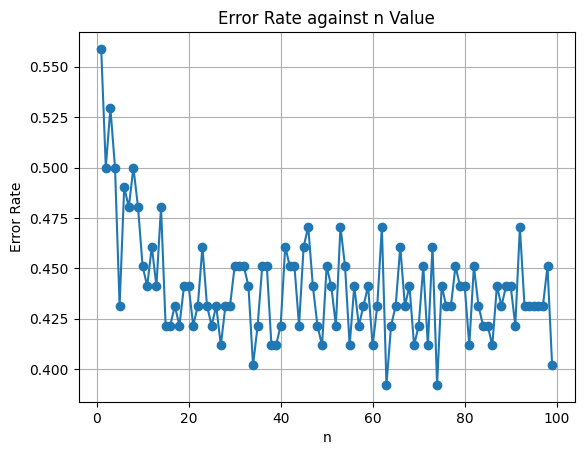

In [13]:
from sklearn.ensemble import RandomForestClassifier


error_rate = []
N = range(1, 100)

for n in N:
    model = RandomForestClassifier(n_estimators=n, criterion='gini')
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    error_rate.append(np.mean(pred != Y_test)) 

plt.plot(N, error_rate, marker='o')
plt.title('Error Rate against n Value')
plt.xlabel('n')
plt.ylabel('Error Rate')
plt.grid()

In [14]:
best_n = np.argmin(error_rate) + 1
model = RandomForestClassifier(n_estimators=best_n,  criterion='gini')
model.fit(X_train, Y_train)
pred = model.predict(X_test)

print(f'Best value of n is {best_n}')
print(confusion_matrix(Y_test, pred))
print(classification_report(Y_test, pred))

RandomForest_score = accuracy_score(Y_test, pred)
print(RandomForest_score)

Best value of n is 63
[[17  0  0  1  2]
 [ 0 16  2  3  0]
 [ 2  0  7  5  7]
 [ 1  2  2  9  5]
 [ 2  0 10  3  6]]
                   precision    recall  f1-score   support

       1. No mine       0.77      0.85      0.81        20
     2. Anti-Tank       0.89      0.76      0.82        21
3. Anti-Personnel       0.33      0.33      0.33        21
    4. Booby-Trap       0.43      0.47      0.45        19
           5. M14       0.30      0.29      0.29        21

         accuracy                           0.54       102
        macro avg       0.54      0.54      0.54       102
     weighted avg       0.54      0.54      0.54       102

0.5392156862745098


# AdaBoost

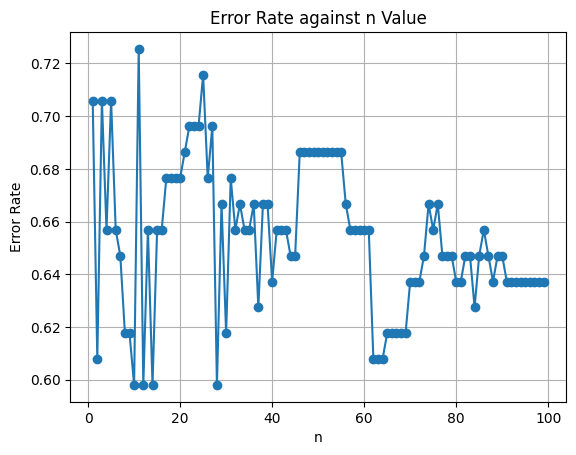

In [15]:
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings('ignore')

error_rate = []
N = range(1, 100)

for n in N:
    model = AdaBoostClassifier(n_estimators=n)
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    error_rate.append(np.mean(pred != Y_test)) 

plt.plot(N, error_rate, marker='o')
plt.title('Error Rate against n Value')
plt.xlabel('n')
plt.ylabel('Error Rate')
plt.grid()


In [16]:
best_n = np.argmin(error_rate) + 1
model = AdaBoostClassifier(n_estimators=best_n)
model.fit(X_train, Y_train)
pred = model.predict(X_test)

print(f'Best value of n is {best_n}')
print(confusion_matrix(Y_test, pred))
print(classification_report(Y_test, pred))

AdaBoost_score = accuracy_score(Y_test, pred)
print(AdaBoost_score)

Best value of n is 10
[[14  0  1  0  5]
 [ 0 14  7  0  0]
 [ 4  1  9  1  6]
 [ 7  1  6  0  5]
 [ 2  2 11  2  4]]
                   precision    recall  f1-score   support

       1. No mine       0.52      0.70      0.60        20
     2. Anti-Tank       0.78      0.67      0.72        21
3. Anti-Personnel       0.26      0.43      0.33        21
    4. Booby-Trap       0.00      0.00      0.00        19
           5. M14       0.20      0.19      0.20        21

         accuracy                           0.40       102
        macro avg       0.35      0.40      0.37       102
     weighted avg       0.36      0.40      0.37       102

0.4019607843137255


# SVM

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid1 = {'C': [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000], 
              'gamma': [10, 5, 3, 2, 1, 0.5, 0.1, 0.01, 0.005, 0.001, 0.0001, 0.00001], 
              'kernel': ['rbf']} 

param_grid2 = {'C': [c for c in np.arange(915, 945, 1)], 
              'gamma': [c for c in np.arange(1.95, 2.15, 0.0025)], 
              'kernel': ['rbf']}

param_grid = param_grid2

grid = GridSearchCV(SVC(), param_grid, refit=True)

grid.fit(X_train, Y_train)

print(grid.best_estimator_)


grid_predictions = grid.predict(X_test)

print(confusion_matrix(Y_test, grid_predictions))
print(classification_report(Y_test, grid_predictions))
SVM_score = accuracy_score(Y_test, grid_predictions)
print(SVM_score)


SVC(C=915, gamma=1.9699999999999995)
[[18  0  0  1  1]
 [ 0 21  0  0  0]
 [ 2  0 11  2  6]
 [ 1  0  1 12  5]
 [ 2  0  6  1 12]]
                   precision    recall  f1-score   support

       1. No mine       0.78      0.90      0.84        20
     2. Anti-Tank       1.00      1.00      1.00        21
3. Anti-Personnel       0.61      0.52      0.56        21
    4. Booby-Trap       0.75      0.63      0.69        19
           5. M14       0.50      0.57      0.53        21

         accuracy                           0.73       102
        macro avg       0.73      0.73      0.72       102
     weighted avg       0.73      0.73      0.72       102

0.7254901960784313


# Висновки

Порівняємо accuracy_score усіх застосованих методів

In [19]:
print(f'KNN: \t\t {KNN_score}')
print(f'SVM: \t\t {SVM_score}')
print(f'DT: \t\t {DT_score}')
print(f'RandomForest: \t {RandomForest_score}')
print(f'AdaBoost: \t {AdaBoost_score}')

KNN: 		 0.5
SVM: 		 0.7254901960784313
DT: 		 0.5392156862745098
RandomForest: 	 0.5392156862745098
AdaBoost: 	 0.4019607843137255
